In [1]:
from keras.models import Sequential,load_model
from keras.layers import Conv2D,Activation, MaxPooling2D,Dense,Flatten
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

In [2]:
def Build_CNN_Model():
    
    # -------------------------------------------------------------------------
    #                        Build CNN Model 
    # -------------------------------------------------------------------------
    model = Sequential()
    
    #  First Block of CNN
    model.add(Conv2D(8, (5, 5), padding='same', input_shape=(224, 224, 3)))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #  Second Block of CNN
    model.add(Conv2D(8, (3, 3),  padding='same'))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    #  Third Block of CNN
    model.add(Conv2D(16, (3, 3),  padding='same'))  
    model.add(Activation('relu'))


    #  Forth Block of CNN
    model.add(Conv2D(16, (3, 3),  padding='same'))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    
    #  Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
     
    #  Softmax Classifier
    model.add(Dense(2))
    model.add(Activation('softmax'))
        
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 


In [3]:
# train and evalluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    
    # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
  
   
    # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('Data/train/',classes =('normal','abnormal'),batch_size=batch_size, target_size=(224, 224))
    valid_it = valid_datagen.flow_from_directory('Data/val/',classes =('normal','abnormal'),batch_size=batch_size, target_size=(224, 224))


    epochs=100;
    
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('medical_diagnosis_cnn_model.h5')
    


In [4]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('Data/test/',classes =('normal','abnormal'), 
                                               shuffle=False,batch_size=batch_size, target_size=(224, 224))
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()
    

In [5]:
# main entry
    
model = Build_CNN_Model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       608       
                                                                 
 activation (Activation)     (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       584       
                                                                 
 activation_1 (Activation)   (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                    

Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


C:\Users\STUDEN~1\AppData\Local\Temp/ipykernel_24112/3292953681.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),


Epoch 1/100
19/19 [==============================] - 31s 2s/step - loss: 0.2158 - accuracy: 0.9233 - val_loss: 0.1608 - val_accuracy: 0.9400
Epoch 2/100
19/19 [==============================] - 30s 2s/step - loss: 0.2947 - accuracy: 0.8767 - val_loss: 0.2335 - val_accuracy: 0.9175
Epoch 3/100
19/19 [==============================] - 31s 2s/step - loss: 0.2874 - accuracy: 0.8950 - val_loss: 0.1892 - val_accuracy: 0.9225
Epoch 4/100
19/19 [==============================] - 31s 2s/step - loss: 0.3002 - accuracy: 0.8967 - val_loss: 0.2192 - val_accuracy: 0.9175
Epoch 5/100
19/19 [==============================] - 31s 2s/step - loss: 0.2179 - accuracy: 0.9217 - val_loss: 0.3390 - val_accuracy: 0.9050
Epoch 6/100
19/19 [==============================] - 34s 2s/step - loss: 0.2339 - accuracy: 0.9117 - val_loss: 0.2707 - val_accuracy: 0.9125
Epoch 7/100
19/19 [==============================] - 47s 3s/step - loss: 0.3100 - accuracy: 0.8650 - val_loss: 0.2514 - val_accuracy: 0.9050
Epoch 8/100
1

Epoch 59/100
19/19 [==============================] - 483s 27s/step - loss: 0.2118 - accuracy: 0.9133 - val_loss: 0.2879 - val_accuracy: 0.8875
Epoch 60/100
19/19 [==============================] - 83s 4s/step - loss: 0.2177 - accuracy: 0.8983 - val_loss: 0.1754 - val_accuracy: 0.9425
Epoch 61/100
19/19 [==============================] - 82s 4s/step - loss: 0.1962 - accuracy: 0.9283 - val_loss: 0.3006 - val_accuracy: 0.9125
Epoch 62/100
19/19 [==============================] - 80s 4s/step - loss: 0.1894 - accuracy: 0.9367 - val_loss: 0.2212 - val_accuracy: 0.9200
Epoch 63/100
19/19 [==============================] - 80s 4s/step - loss: 0.1928 - accuracy: 0.9233 - val_loss: 0.2269 - val_accuracy: 0.9325
Epoch 64/100
19/19 [==============================] - 79s 4s/step - loss: 0.1798 - accuracy: 0.9250 - val_loss: 0.1531 - val_accuracy: 0.9450
Epoch 65/100
19/19 [==============================] - 79s 4s/step - loss: 0.2272 - accuracy: 0.9083 - val_loss: 0.2008 - val_accuracy: 0.9325
Epoc

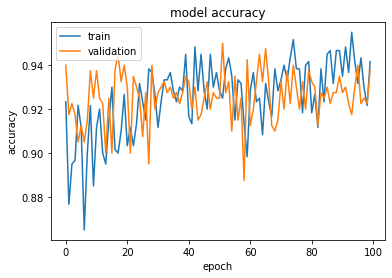

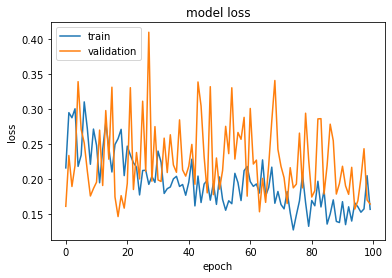

In [7]:
Train_CNN_Model(model)

Found 624 images belonging to 2 classes.


C:\Users\STUDEN~1\AppData\Local\Temp/ipykernel_24112/920839411.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)


20/20 [==============================] - 26s 1s/step


No handles with labels found to put in legend.



Confusion Matrix
 -------------------------
[[150  84]
 [ 12 378]]
Accuracy: 0.846154
Precision: 0.818182
Recall: 0.969231
F1 score: 0.887324
ROC AUC: 0.933235


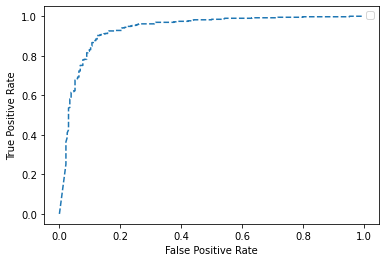

In [8]:
Evaluate_CNN_Model()